In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as T
import torchvision
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

import sys
sys.path.append("..")

from mlelib import *
%matplotlib inline

In [2]:
NUM_WORKERS = 8
BATCH_SIZE = 128
INPUT_SIZE = 28
LR = 4e-4
NUM_EPOCHS = 10
DEVICE = "cuda:0"

# Model

In [3]:
class ModelWrapper(nn.Module):
    def __init__(self, backbone_model, features=512, num_classes=10):
        super().__init__()
        self.base_model = backbone_model
        self.features = nn.Linear(features, 2)
        self.classifier = nn.Linear(2, num_classes)
    
    def forward(self, x, labels=None, return_embeddings=False):
        emb1 = self.base_model(x)
        emb2 = self.features(emb1)
        logits = self.classifier(emb2)

        return_values = [logits]

        if labels is not None:
            loss = nn.functional.cross_entropy(logits, labels)
            loss += torch.pow(self.classifier.weight.norm(dim=1)-1, 2).sum()
            return_values += [loss]
        
        if return_embeddings:
            return_values += [emb2.detach()]
            
        return return_values

backbone_model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
backbone_model.fc = nn.Identity()

model = ModelWrapper(backbone_model)
#model(torch.rand(2,3,28,28), labels=torch.tensor([2]))


# Datasets

In [4]:
def convert_rgb(img):
    return img.convert("RGB")

# Train loader
tr_train = T.Compose([convert_rgb,
                      T.RandomResizedCrop((INPUT_SIZE, INPUT_SIZE), (0.9, 1)),
                      T.RandomRotation(5),
                      T.ToTensor()])
data_train = MNIST(root=".",train=True,transform=tr_train, download=True)
# test loader
tr_test = T.Compose([T.Resize((INPUT_SIZE, INPUT_SIZE)),
                     convert_rgb,
                     T.ToTensor()])

data_test = MNIST(root=".",train=False,transform=tr_test)

In [5]:
trainer = Trainer(model,
                  output_dir="outputs",
                  lr=LR,
                  n_epochs=20,
                  num_workers=0,
                  device="cuda")
trainer.fit(data_train, data_test)

Training: 100%|██████████| 1875/1875 [01:08<00:00, 27.38it/s, loss=0.437]


epoch 0 Mean Train Loss 1.2609692914326986


100%|██████████| 313/313 [00:02<00:00, 114.00it/s]


epoch 0 Val Loss 0.32200491823517857


Training: 100%|██████████| 1875/1875 [01:08<00:00, 27.34it/s, loss=0.22]  


epoch 1 Mean Train Loss 0.3411572155058384


100%|██████████| 313/313 [00:02<00:00, 115.72it/s]


epoch 1 Val Loss 0.17685095988475857


Training:   1%|          | 10/1875 [00:00<01:05, 28.28it/s, loss=0.0876]

KeyboardInterrupt: 

In [6]:
embeddings = trainer.get_embeddings(data_train, model, return_labels=True, to_numpy=True)

100%|██████████| 1875/1875 [00:24<00:00, 76.95it/s].28it/s, loss=0.0876]


In [7]:
embeddings[0].shape

(60000, 2)

# Optimization

In [8]:
cmap = plt.get_cmap("Paired")
cmap_colors = cmap.colors

In [9]:
def visualize_features(fig, ax, features, labels, title=""):
    ax.clear()
    scatter = ax.scatter(features[:,0],
                  features[:,1],
                  s = 10,
                  c=list(map(lambda x: cmap_colors[x], labels)),
                  cmap="Paired")

    ax.legend(labels=range(10),
              loc="upper right",
              labelcolor=list(cmap_colors[:10]),
              fontsize=8)
    
    ax.title.set_text(title)

    fig.canvas.draw()
    fig.canvas.flush_events()

In [10]:
def visualize_weights(fig, ax, weights):
    num_classes = weights.shape[0]
    ax.quiver(*np.zeros((2, num_classes)), weights[:,0], weights[:,1])
    
    for i in range(num_classes):
        l = mlines.Line2D([0,weights[i,0]*100], [0,weights[i,1]*100], color=cmap_colors[i])
        ax.add_line(l)
        
    fig.canvas.draw()
    fig.canvas.flush_events()

C:\Users\alenic\AppData\Local\Temp\ipykernel_13936\3355074557.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(features[:,0],


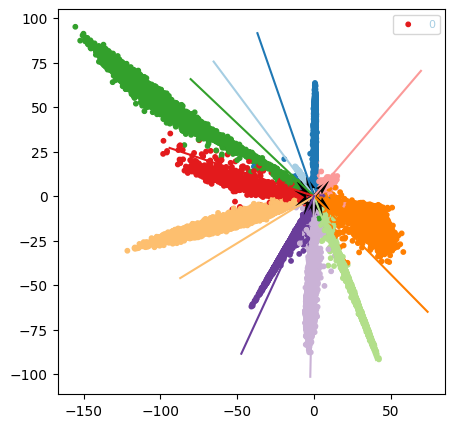

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
plt.ion()
visualize_features(fig, ax, embeddings[0], labels=embeddings[1])
weights = model.classifier.weight.data.cpu().numpy()
visualize_weights(fig, ax, weights)

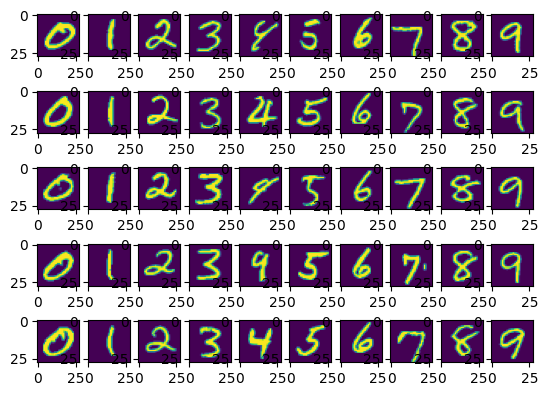

In [12]:
# Best 5
data_train_raw = MNIST(root=".",train=True, transform=None)
max_output = (weights @ embeddings[0].T).max(0)

fig, ax = plt.subplots(5, 10)
for label_class in range(10):
    indices = np.where(embeddings[1]==label_class)[0]
    max_i = max_output[indices].argsort()[::-1]
    max_index = indices[max_i[:5]]
    for i in range(5):
        ax[i, label_class].imshow(data_train_raw[max_index[i]][0])

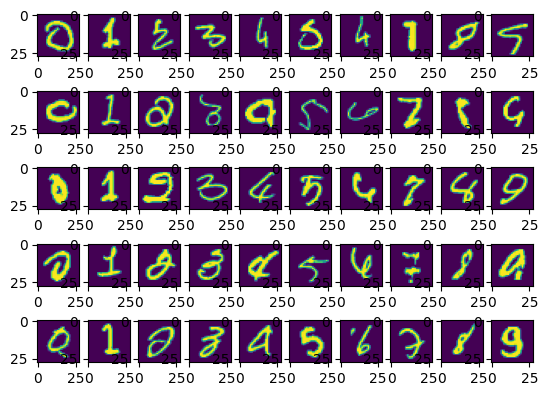

In [13]:
# Worst 5
fig, ax = plt.subplots(5, 10)
for label_class in range(10):
    indices = np.where(embeddings[1]==label_class)[0]
    max_i = max_output[indices].argsort()
    max_index = indices[max_i[:5]]
    for i in range(5):
        ax[i, label_class].imshow(data_train_raw[max_index[i]][0])